In [1]:
import pandas as pd
import numpy as np

import trading_strategy_utils as tsu
import update_dataframe as ud
import sharpe_ratio_utils as sru

In [2]:
def normalize_allocations(allocations):
    allocations = [round(alloc, 8) for alloc in allocations]
    total = sum(allocations)
    
    if total == 0:
        return allocations
    
    if total > 1:
        excess = total - 1
        max_alloc = max(allocations)
        max_index = allocations.index(max_alloc)
        allocations[max_index] = round(allocations[max_index] - excess, 8)
    
    return allocations

def generate_allocation_prediction(pnl_df_list_for_date, dfs_result_list, window_params):
    """
    Generate allocation plan for the future hour, based on the current and historical pnl data.

    Parameters:
    pnl_df_list_for_date (list): List of DataFrames containing pnl data up to the current date for each cryptocurrency.
    dfs_result_list (list): List of DataFrames to store the updated results for each cryptocurrency.
    params (dict): Dictionary containing short_window and long_window parameters for each cryptocurrency.

    Returns:
    dfs_result_list (list): Updated list of DataFrames with new rows added.
    normalized_allocations (list): List of normalized allocations for each cryptocurrency.
    """
    cryptos = ["BTC", "ETH", "ADA", "DOGE"]
    
    pnl_last_value_list = [pnl_df_list_for_date[i].iloc[-1] for i in range(len(cryptos))]
    for i in range(len(cryptos)):
        new_row = pd.DataFrame({'pnl': [pnl_last_value_list[i]]})
        dfs_result_list[i] = pd.concat([dfs_result_list[i], new_row], ignore_index=True)
    
    weight_percentage_list = []
    for i in range(len(cryptos)):
        df_new = dfs_result_list[i]
        df_new = ud.update_dataframe_with_new_row(df_new, {'pnl': pnl_last_value_list[i]}, [], short_window=window_params[cryptos[i]]['short_window'], long_window=window_params[cryptos[i]]['long_window'])
        dfs_result_list[i] = df_new
        weight_percentage_list.append(df_new['weight_percentage'].iloc[-1] / 100.0)
    print(f"weight_percentage_list(0-1): {weight_percentage_list}")
    
    sharpe_ratio_list = []
    for i in range(len(cryptos)):
        df = dfs_result_list[i]
        sharpe_ratio = sru.calculate_sharpe_ratio(df['pnl'])
        sharpe_ratio_list.append(sharpe_ratio)
    # print(f"sharpe_ratio list: {sharpe_ratio_list}")
    
    true_weights_portion = sru.calculate_true_weights(sharpe_ratio_list)
    # print(f"final true weights protion(0-1): {true_weights_portion}")
    
    initial_allocations = [weight_percentage_list[i] * true_weights_portion[i] for i in range(len(cryptos))]
    # print(f"initial allocations: {initial_allocations}")
    
    normalized_allocations = normalize_allocations(initial_allocations)
    print(f"normalized allocations: {normalized_allocations}")
    
    return dfs_result_list, normalized_allocations

In [4]:
def evaluate_strategy(pnl_df_list):
    cumulative_return = 1
    date_range = pd.date_range(start='2022-10-01 00:00:00', end='2022-11-10 00:00:00', freq='H')
    date_strings = date_range.strftime('%Y-%m-%dT%H:%M:%S').tolist()

    # added for updating the result
    for df in pnl_df_list:
        df['ts_hour'] = pd.to_datetime(df['ts_hour'])
    
    # get the select data start from the start time, before the emn long window
    cumulative_return_list = [[],[],[],[]]
    ema_long_window = 11
    start_before_ema_long = date_range[0] - pd.Timedelta(hours=ema_long_window)
    
    dict_lagged_ahead_emg_long = {}
    for crypto, df in zip(cryptos, pnl_df_list):
        df_filtered = df[(df['ts_hour'] >= start_before_ema_long) & (df['ts_hour'] < date_range[0])]
        df_filtered = df_filtered[['pnl']]
        dict_lagged_ahead_emg_long[crypto] = df_filtered

    dfs_result_list = [pd.DataFrame(columns=['pnl', 'EMA_short', 'EMA_long', 'is_positive', 'signal', 'count', 'consistency', 'is_continuous', 'class', 'weight_percentage', 'weight', 'weighted_pnl']) for _ in cryptos]
    
    # put the data into the dfs_result_list 
    for i in range(len(cryptos)):
        dfs_result_list[i] = pd.concat([dfs_result_list[i], dict_lagged_ahead_emg_long[cryptos[i]]])

    window_params = {
        "BTC": {"short_window": 4, "long_window": 12},
        "ETH": {"short_window": 4, "long_window": 11},
        "ADA": {"short_window": 6, "long_window": 13},
        "DOGE": {"short_window": 6, "long_window": 14}
    }
    
    pnl_dict = {crypto: df.set_index('ts_hour')['pnl'] for crypto, df in zip(cryptos, pnl_df_list)}
    
    for i in range(len(date_strings) - 1):
        date_string = date_strings[i]
        next_date_string = date_strings[i + 1]
        pnl_df_list_for_date = [pnl_dict[crypto].loc[:date_string] for crypto in cryptos]
        next_hour_pnl_list = [pnl_dict[crypto].get(next_date_string, 0) for crypto in cryptos]
        
        df_to_update, allocation = generate_allocation_prediction(pnl_df_list_for_date, dfs_result_list, window_params)
        
        for i in range(len(cryptos)):
            dfs_result_list[i] = df_to_update[i]
        
        if len(allocation) != len(pnl_df_list):
            raise ValueError("Allocation length does not match the number of cryptocurrencies")
        if sum(allocation) > 1:
            raise ValueError("Sum of allocation is greater than 1")

        period_return = 0
        for j in range(len(allocation)):
            weighted_pnl = allocation[j] * next_hour_pnl_list[j] if next_hour_pnl_list[j] > 0 else 0
            cumulative_return_list[j].append(weighted_pnl)
            period_return += weighted_pnl

        cumulative_return = cumulative_return * (1 + period_return)
        
        print(f"next_hour_pnl_list: {next_hour_pnl_list}")
        print(f"cumulative_return_list: {cumulative_return_list[0][-1]}, {cumulative_return_list[1][-1]}, {cumulative_return_list[2][-1]}, {cumulative_return_list[3][-1]}")
        print(f"cumulative_return: {cumulative_return}\n")
        
        # break
    
    return cumulative_return, dfs_result_list, date_range, cumulative_return_list

In [5]:
cryptos = ["BTC", "ETH", "ADA", "DOGE"]
pnl_df_list = [pd.read_csv(f'data/{crypto}.csv') for crypto in cryptos]
cumulative_return, dfs_result_list, date_range, cumulative_return_list = evaluate_strategy(pnl_df_list)

weight_percentage_list(0-1): [0.4875, 0.4875, 0.0, 0.0]
normalized allocations: [0.06159182, 0.09058842, 0.0, 0.0]
next_hour_pnl_list: [-0.0001545784112047, 0.0005812136691013, 0.0010826338967697, 0.0025456104835596]
cumulative_return_list: 0, 5.265122796628959e-05, 0.0, 0.0
cumulative_return: 1.0000526512279664

weight_percentage_list(0-1): [0.0, 0.4875, 1.0, 0.4875]
normalized allocations: [0.0, 0.09998885, 0.40456622, 0.12159243]
next_hour_pnl_list: [0.0003217431934001, 0.0001046403899279, -0.0001162326373877, -0.0054933620076651]
cumulative_return_list: 0.0, 1.0462872252442304e-05, 0, 0
cumulative_return: 1.0000631146511019

weight_percentage_list(0-1): [0.4875, 0.4875, 0.0, 0.0]
normalized allocations: [0.07056988, 0.10330224, 0.0, 0.0]
next_hour_pnl_list: [-0.0001010207619425, -0.0001449157497329, -0.0007255020813289, 0.0023744025471201]
cumulative_return_list: 0, 0, 0, 0.0
cumulative_return: 1.0000631146511019

weight_percentage_list(0-1): [0.0, 0.0, 0.0, 1.0]
normalized allocat

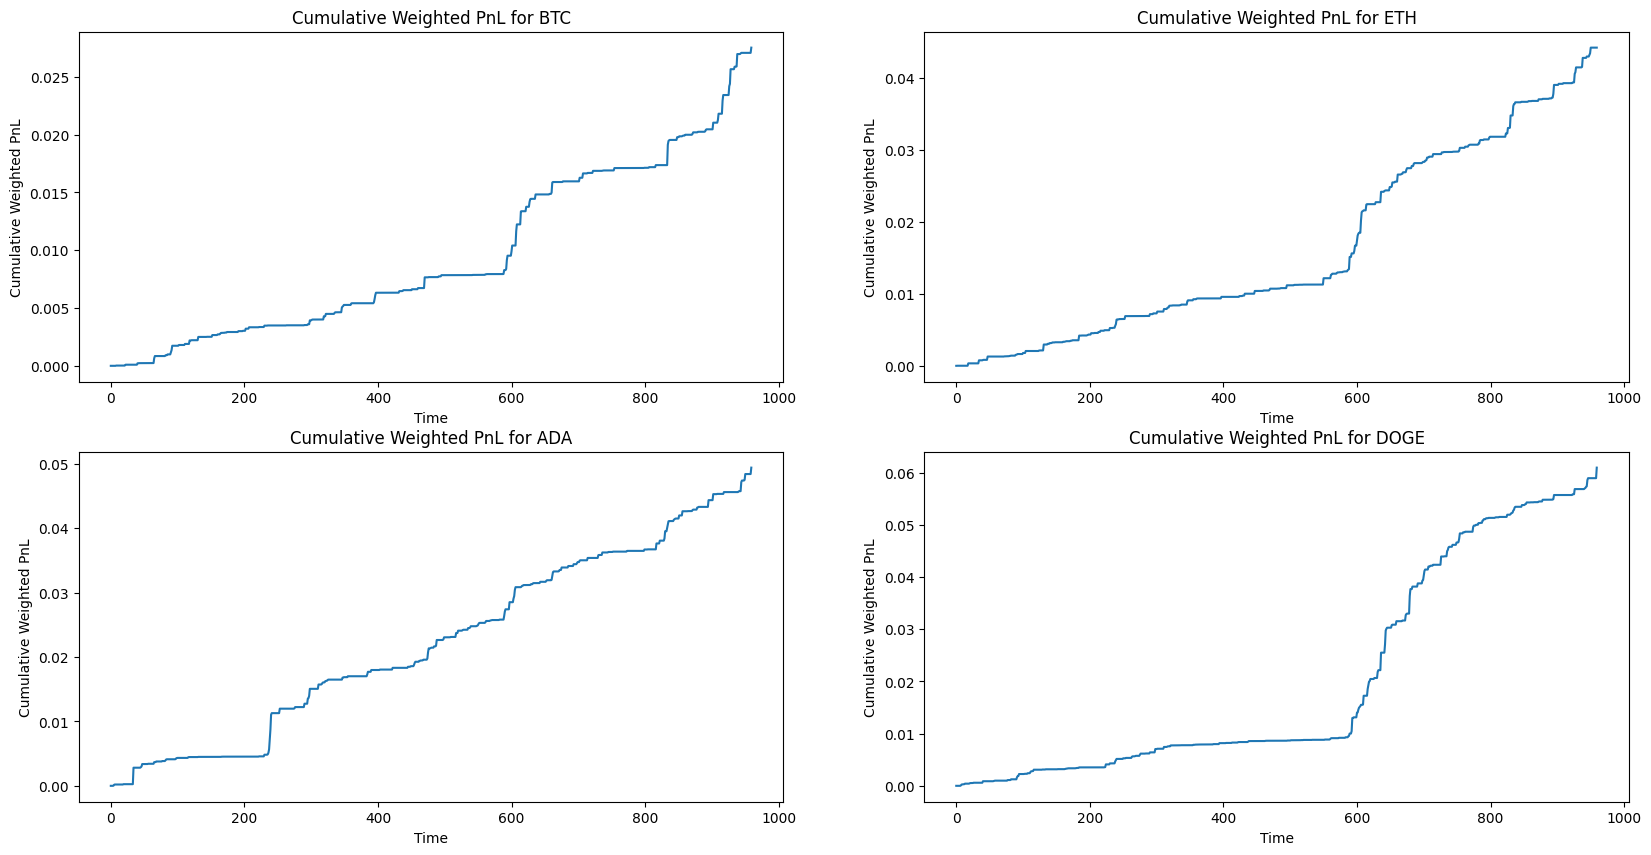

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i in range(4):
    cumulative_weight_pnl = pd.Series(cumulative_return_list[i])
    cumulative_weight_pnl = cumulative_weight_pnl.cumsum()
    ax[i // 2, i % 2].plot(cumulative_weight_pnl)
    ax[i // 2, i % 2].set_title(f'Cumulative Weighted PnL for {cryptos[i]}')
    ax[i // 2, i % 2].set_xlabel('Time')
    ax[i // 2, i % 2].set_ylabel('Cumulative Weighted PnL')
plt.show()